In [1]:
import matplotlib.pyplot as plot
import numpy as np
import scipy.spatial.distance as spsd
from sklearn import preprocessing

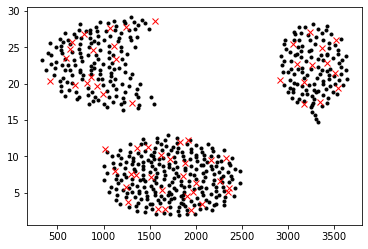

In [2]:
data = np.loadtxt('cluster.dat')

testing = np.array([ item for index, item in enumerate(data) if index % 10 == 0 ])
training = np.array([ item for index, item in enumerate(data) if index % 10 >= 1 ])

plot.plot(training[:,0], training[:,1], '.', color='black')
plot.plot(testing[:,0], testing[:,1], 'x', color='red')
plot.show()

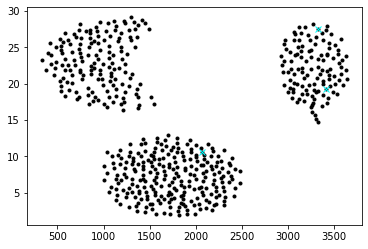

In [3]:
def pick_cluster_centers(array, k):
    centers = []
    for i in range(k):
        p_dist = np.ones(array.shape[0])
        for j in range(array.shape[0]):
            if centers:
                distances = spsd.cdist(np.array([array[j]]), centers)
                p_dist[j] = min(distances)[0]
        p_dist /= sum(p_dist)
        ai = np.random.choice(array.shape[0], p = p_dist)
        centers.append(array[ai])
    return np.array(centers)

centers = pick_cluster_centers(training, 3)

plot.plot(training[:,0], training[:,1], '.', color='black')
plot.plot(centers[:,0], centers[:,1], 'x', color='cyan')
plot.show()

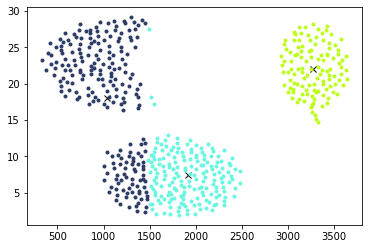

In [5]:
def get_cluster_data(array, centers):
    distances = spsd.cdist(array, centers)
    clusterization = np.argmin(distances, axis=1)
    clusters = {}
    for i in range(centers.shape[0]):
        indices = np.where(clusterization == i)
        clusters[i] = np.take(array, indices, 0)
    return clusters

def kmeans(array, k, diff=0.1):
    centers = pick_cluster_centers(array, k)

    changed = True
    while (changed):
        clusters = get_cluster_data(array, centers)
        
        new_centers = np.empty(centers.shape)
        for i in range(k):
            new_centers[i] = np.mean(clusters[i], 1)
        
        if abs(np.sum(new_centers - centers)) > diff:
            centers = new_centers
        else:
            changed = False
    return centers

cluster_centers = kmeans(training, 3)
clusters = get_cluster_data(training, cluster_centers)
plot.plot(cluster_centers[:,0], cluster_centers[:,1], 'x', color='black')
for i in clusters:
    plot.plot(clusters[i][0,:,0], clusters[i][0,:,1], '.', color=np.random.rand(3,))
plot.show()

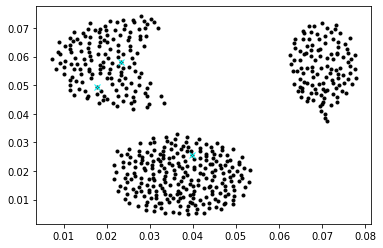

In [6]:
def normalize(array):
    normalized_array = preprocessing.normalize(array, axis=0)
    return normalized_array

new_training = normalize(training)
new_centers = kmeans(new_training, 3)

plot.plot(new_training[:,0], new_training[:,1], '.', color='black')
plot.plot(new_centers[:,0], new_centers[:,1], 'x', color='cyan')
plot.show()

In [7]:
import json

def covid_dataset_cleaner(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)

    matriz = {}
    notCountries = ["World", "Africa", "Europe", "European Union", "Asia", "North America", "South America", "Oceania", "International"]

    for country in data:
        if not (data[country]['location'] in notCountries):
            location = data[country]['location']
            newCountry = []
            
            lastMonth = str(data[country]['data'][0]['date'][5]) + str(data[country]['data'][0]['date'][6]) + '/' + str(data[country]['data'][0]['date'][2]) + str(data[country]['data'][0]['date'][3])
            lastData = []
            
            if lastMonth == '04/20':
                newCountry.append([0, '2020-03-31'])
            
            elif lastMonth == '05/20':
                newCountry.append([0, '2020-03-31'])
                newCountry.append([0, '2020-04-30'])

            for daysInformation in data[country]['data']:
                newMonth = str(daysInformation['date'][5]) + str(daysInformation['date'][6]) + '/' + str(daysInformation['date'][2]) + str(daysInformation['date'][3])

                if newMonth == '01/20' or newMonth == '02/20':
                    lastMonth = '03/20'
                    continue

                if lastMonth != newMonth:
                    newCountry.append(lastData)

                deaths = 0
                if 'total_deaths' in daysInformation:
                    deaths = daysInformation['total_deaths']

                lastMonth = newMonth
                lastData =  [deaths, daysInformation['date']]
                
            if len(newCountry) == 13:
                matriz[location] = newCountry
                
    # teste = []
    # for country in matriz:
        # print(country, ":", len(matriz[country]))
    

    return matriz


covid_dataset = covid_dataset_cleaner('covid-data.json')
print(covid_dataset)

{'Afghanistan': [[4.0, '2020-03-31'], [64.0, '2020-04-30'], [258.0, '2020-05-31'], [752.0, '2020-06-30'], [1284.0, '2020-07-31'], [1403.0, '2020-08-31'], [1460.0, '2020-09-30'], [1538.0, '2020-10-31'], [1795.0, '2020-11-30'], [2191.0, '2020-12-31'], [2400.0, '2021-01-31'], [2443.0, '2021-02-28'], [2484.0, '2021-03-31']], 'Albania': [[15.0, '2020-03-31'], [31.0, '2020-04-30'], [33.0, '2020-05-31'], [62.0, '2020-06-30'], [157.0, '2020-07-31'], [284.0, '2020-08-31'], [387.0, '2020-09-30'], [509.0, '2020-10-31'], [810.0, '2020-11-30'], [1181.0, '2020-12-31'], [1380.0, '2021-01-31'], [1796.0, '2021-02-28'], [2235.0, '2021-03-31']], 'Algeria': [[44.0, '2020-03-31'], [450.0, '2020-04-30'], [653.0, '2020-05-31'], [912.0, '2020-06-30'], [1210.0, '2020-07-31'], [1510.0, '2020-08-31'], [1736.0, '2020-09-30'], [1964.0, '2020-10-31'], [2431.0, '2020-11-30'], [2756.0, '2020-12-31'], [2891.0, '2021-01-31'], [2983.0, '2021-02-28'], [3093.0, '2021-03-31']], 'Andorra': [[12.0, '2020-03-31'], [42.0, '202